<a href="https://colab.research.google.com/github/belovelace/Machine_learning_class/blob/main/WISDM_lstm_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, InputLayer, Dropout, Flatten, BatchNormalization, Conv1D
from tensorflow.keras.layers import concatenate
from keras.utils import to_categorical
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats

# Import necessary layers for the CNN-Transformer model
from tensorflow.keras.layers import Conv2D, MultiHeadAttention, LayerNormalization, Add, Reshape, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:

from google.colab import drive

drive.mount('/content/drive', force_remount=True)

df = pd.read_csv("/content/drive/MyDrive/AI_study/WISDM_ar_v1.1_raw.txt",
                 header=None,
                 sep=',',
                 names=['user', 'activity', 'timestamp', 'x', 'y', 'z'],
                 on_bad_lines='skip')

Mounted at /content/drive


In [ ]:

df['z'] = df['z'].astype(str).str.replace(';', '').str.strip()

# 결측값 제거
df = df.dropna()

print(f"데이터 로딩 완료: {df.shape}")
df.head()


데이터 로딩 완료: (1086466, 6)


,user,activity,timestamp,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [ ]:
label=LabelEncoder()
df['activity']=label.fit_transform(df['activity'])
df

,user,activity,timestamp,x,y,z
0,33,1,49105962326000,-0.694638,12.680544,0.50395286
1,33,1,49106062271000,5.012288,11.264028,0.95342433
2,33,1,49106112167000,4.903325,10.882658,-0.08172209
3,33,1,49106222305000,-0.612916,18.496431,3.0237172
4,33,1,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1086461,19,2,131623331483000,9.000000,-1.570000,1.69
1086462,19,2,131623371431000,9.040000,-1.460000,1.73
1086463,19,2,131623411592000,9.080000,-1.380000,1.69
1086464,19,2,131623491487000,9.000000,-1.460000,1.73


In [ ]:

print(f"df 존재: {'df' in globals()}")
if 'df' in globals():
    print(f"df 크기: {df.shape}")
    print(f"df 비어있음: {df.empty}")


df 존재: True
df 크기: (1086466, 6)
df 비어있음: False


In [ ]:
df['activity'].value_counts()

,count
activity,
5,418394
1,336445
4,122869
0,100425
2,59939
3,48394


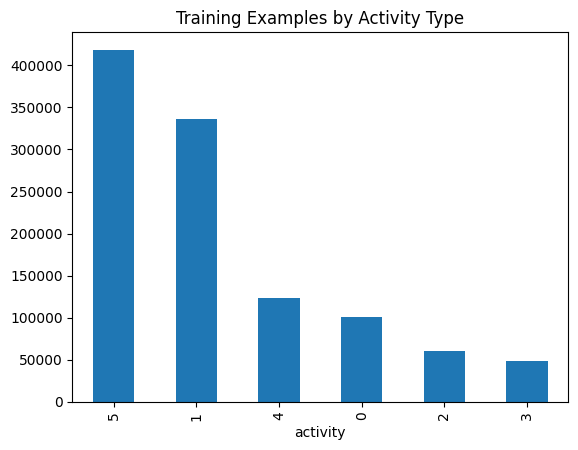

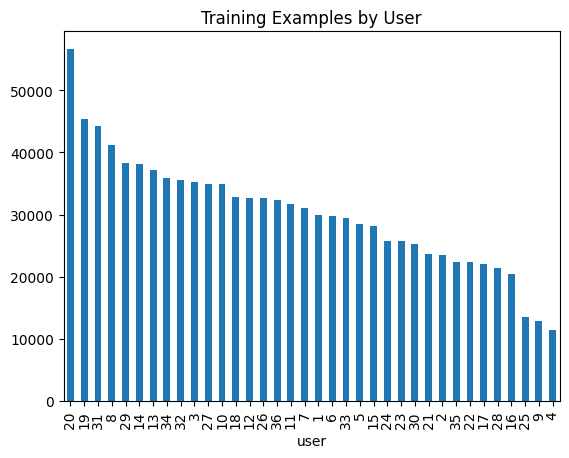

In [ ]:
# Show how many training examples exist for each of the six activities
df["activity"].value_counts().plot(kind = "bar", title = "Training Examples by Activity Type")
plt.show()
# Better understand how the recordings are spread across the different users who participated in the study
df["user"].value_counts().plot(kind = "bar", title = "Training Examples by User")
plt.show()

In [ ]:
df['x'] = df['x'].astype('float')
df['y'] = df['y'].astype('float')
df['z'] = df['z'].astype('float')

In [ ]:
users=sorted(df['user'].unique())
print(users)

[np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36)]


In [ ]:
#train, test 분리
train_users=[u for u in users if u<=28]
val_users=[u for u in users if 2832]
test_users=[u for u in users if u>32]

#사용자 그룹에 따라 DataFrame 생성
train_df = df[df['user'].isin(train_users)].copy()
test_df  = df[df['user'].isin(test_users)].copy()
val_df=df[df['user'].isin(val_users)].copy()

# NaN 값 제거
train_df = train_df.dropna()
val_df = val_df.dropna()
test_df = test_df.dropna()


print("======데이터 분할(사용자 기반)=====")
print(f"훈련용 사용자 수: {len(train_users)}명, 데이터 수: {len(train_df)}")
print(f"검증용 사용자 수: {len(val_users)}명, 데이터 수: {len(val_df)}")
print(f"테스트용 사용자 수: {len(test_users)}명, 데이터 수: {len(test_df)}")

======데이터 분할(사용자 기반)=====
훈련용 사용자 수: 28명, 데이터 수: 823043
검증용 사용자 수: 36명, 데이터 수: 1086465
테스트용 사용자 수: 4명, 데이터 수: 120055


In [ ]:
# Define the features to be scaled
features = ['x', 'y', 'z']

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform all dataframes
scaler.fit(train_df[features])        # 훈련 데이터로만 학습
train_df[features] = scaler.transform(train_df[features])  # 동일 기준 적용
val_df[features] = scaler.transform(val_df[features])      # 동일 기준 적용
test_df[features] = scaler.transform(test_df[features])    # 동일 기준 적용

print("데이터 스케일링 완료")

데이터 스케일링 완료


In [ ]:
def segments(df, time_steps, step, label_name):
    N_FEATURES = 3
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x'].values[i:i+time_steps]
        ys = df['y'].values[i:i+time_steps]
        zs = df['z'].values[i:i+time_steps]

        win_labels = df[label_name].values[i:i+time_steps].astype(int)
        label = np.bincount(win_labels).argmax()
        segments.append([xs, ys, zs])
        labels.append(label)

    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

In [ ]:
TIME_PERIOD = 80
STEP_DISTANCE = 40
LABEL = 'activity'

In [ ]:
train_df = train_df.dropna()
val_df = val_df.dropna()
test_df = test_df.dropna()

In [ ]:
#훈련 데이터셋
x_train, y_train=segments(train_df, TIME_PERIOD, STEP_DISTANCE, LABEL)

#검증 데이터셋
x_val, y_val=segments(val_df, TIME_PERIOD, STEP_DISTANCE, LABEL)

#테스트 데이터셋
x_test, y_test=segments(test_df, TIME_PERIOD, STEP_DISTANCE, LABEL)

#원핫인코딩
from tensorflow.keras.utils import to_categorical

num_classes=label.classes_.size
y_train_hot=to_categorical(y_train, num_classes)
y_val_hot=to_categorical(y_val, num_classes)
y_test_hot=to_categorical(y_test, num_classes)

# x_train = x_train / np.max(np.abs(x_train)) # 이 부분 제거
# x_val = x_val / np.max(np.abs(x_val)) # 이 부분 제거

print("훈련 데이터:", x_train.shape, y_train_hot.shape)
print("검증 데이터", x_val.shape, y_val_hot.shape)

print("====================================")

# x_train = x_train.reshape(x_train.shape[0], TIME_PERIOD, 3, 1) # 제거
# x_val = x_val.reshape(x_val.shape[0], TIME_PERIOD, 3, 1) # 제거
# x_test = x_test.reshape(x_test.shape[0], TIME_PERIOD, 3, 1) # 제거

x_train.shape, x_val.shape

훈련 데이터: (20575, 80, 3) (20575, 6)
검증 데이터 (27160, 80, 3) (27160, 6)


((20575, 80, 3), (27160, 80, 3))

In [ ]:

# 스케일링된 훈련 데이터 (x_train)의 통계 정보 확인
print("x_train descriptive statistics:")
print("Mean:", np.mean(x_train))
print("Standard Deviation:", np.std(x_train))
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

# x_train에 nan 또는 무한대 값이 있는지 확인
print("\nChecking x_train for NaN and Inf values:")
print("Contains NaN:", np.isnan(x_train).any())
print("Contains Inf:", np.isinf(x_train).any())

x_train descriptive statistics:
Mean: -5.122355e-06
Standard Deviation: 1.0000106
Min: -4.1887546
Max: 3.958978

Checking x_train for NaN and Inf values:
Contains NaN: False
Contains Inf: False


In [ ]:
# 원-핫 인코딩된 훈련 레이블 (y_train_hot) 확인
print("y_train_hot shape:", y_train_hot.shape)

# y_train_hot에 nan 또는 무한대 값이 있는지 확인
print("\nChecking y_train_hot for NaN and Inf values:")
print("Contains NaN:", np.isnan(y_train_hot).any())
print("Contains Inf:", np.isinf(y_train_hot).any())

# 각 샘플의 레이블 합계 확인 (원-핫 인코딩 확인)
print("\nChecking sum of each row in y_train_hot:")
row_sums = np.sum(y_train_hot, axis=1)
print("All row sums are 1:", np.all(row_sums == 1))
print("Unique row sums:", np.unique(row_sums))

# y_train_hot의 값 범위 확인
print("\ny_train_hot value range:")
print("Min value:", np.min(y_train_hot))
print("Max value:", np.max(y_train_hot))

y_train_hot shape: (20575, 6)

Checking y_train_hot for NaN and Inf values:
Contains NaN: False
Contains Inf: False

Checking sum of each row in y_train_hot:
All row sums are 1: True
Unique row sums: [1.]

y_train_hot value range:
Min value: 0.0
Max value: 1.0


### LSTM을 해봅시다
주요 게이트
- Forget Gate (망각 게이트): 이전 셀 상태에서 어떤 정보를 버릴지 결정
- Input Gate (입력 게이트): 새로운 정보 중 어떤 것을 저장할지 결정
- Output Gate (출력 게이트): 셀 상태를 기반으로 어떤 부분을 출력할지 결정

In [ ]:
N_FEATURES = 3

model = Sequential()

# 레이어 적용

model.add(LSTM(
    128,                  # 128개의 LSTM 유닛
    return_sequences=True,  # 다음 레이어로 시퀀스 전달
    input_shape=(TIME_PERIOD, N_FEATURES), # 입력 형태: (80, 3)
    kernel_regularizer=l2(0.001)  # L2 정규화
))

model.add(Dropout(0.5))

model.add(LSTM(
    128,        # 128개의 LSTM 유닛
    kernel_regularizer=l2(0.001)
))
model.add(Dropout(0.5))


model.add(BatchNormalization()) # 배치 정규화 레이어
model.add(Dense(num_classes, activation='softmax')) # 완전연결층

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
optimizer = Adam(learning_rate=0.001)

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)


model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 80, 128)        │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 80, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,454 (783.02 KB)

 Trainable params: 200,198 (782.02 KB)

 Non-trainable params: 256 (1.00 KB)

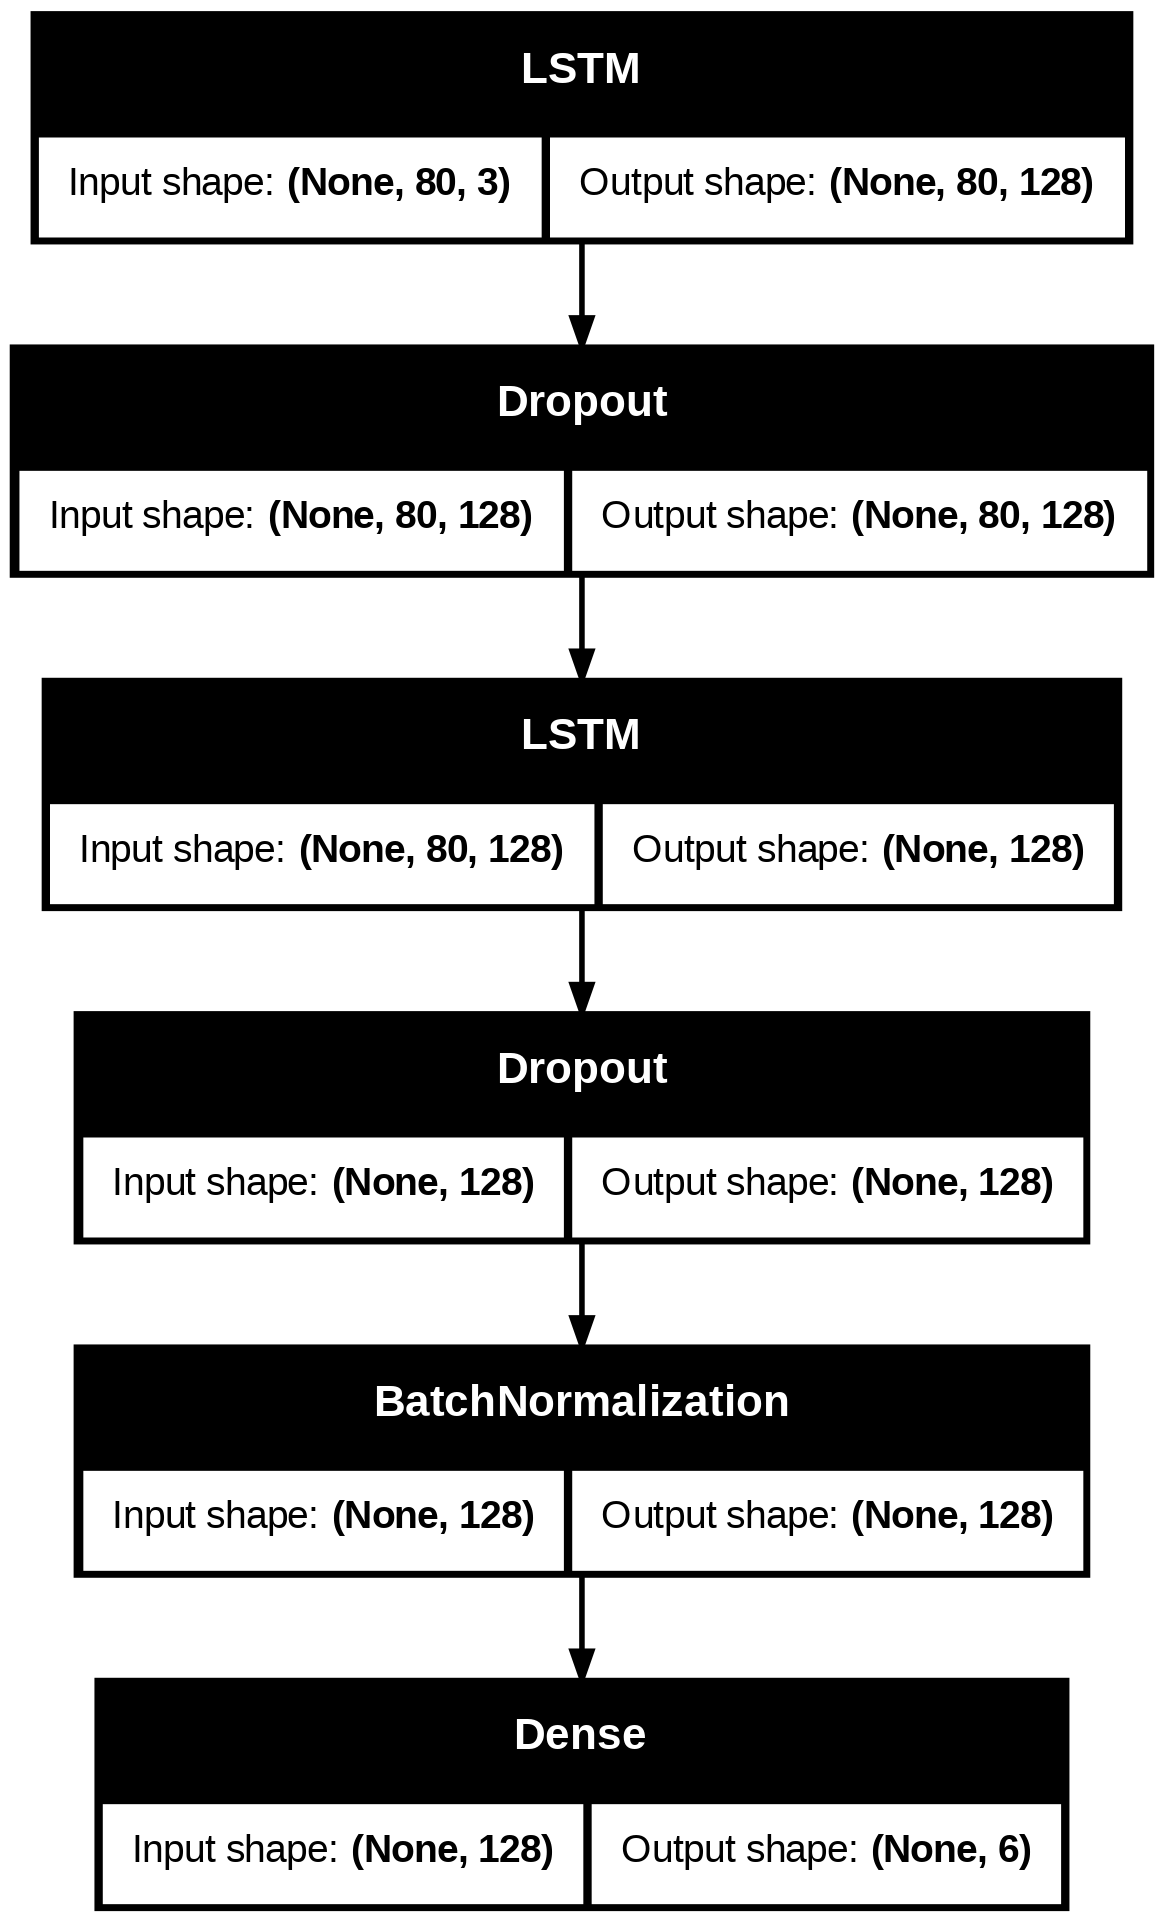

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

print("계산된 클래스 가중치:", class_weights_dict)

계산된 클래스 가중치: {0: np.float64(1.8377098963915683), 1: np.float64(0.5336393816785974), 2: np.float64(3.2721055979643765), 3: np.float64(4.111710631494804), 4: np.float64(1.4660823713837823), 5: np.float64(0.4253493756718763)}


In [ ]:
history = model.fit(
    x_train,
    y_train_hot,
    batch_size=192,
    epochs=50,
    validation_data=(x_val, y_val_hot),
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.4508 - loss: 1.5101 - val_accuracy: 0.6952 - val_loss: 1.1150 - learning_rate: 0.0010
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7029 - loss: 0.8403 - val_accuracy: 0.7227 - val_loss: 0.9286 - learning_rate: 0.0010
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7449 - loss: 0.7169 - val_accuracy: 0.7134 - val_loss: 0.8652 - learning_rate: 0.0010
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7476 - loss: 0.6927 - val_accuracy: 0.6476 - val_loss: 0.8889 - learning_rate: 0.0010
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7829 - loss: 0.6267 - val_accuracy: 0.5547 - val_loss: 1.0844 - learning_rate: 0.0010
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7800 - loss: 0.5631 - val_accuracy: 0.7494 - val_loss: 0.7359 - learning_rate: 0.0010
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7867 - loss: 0.

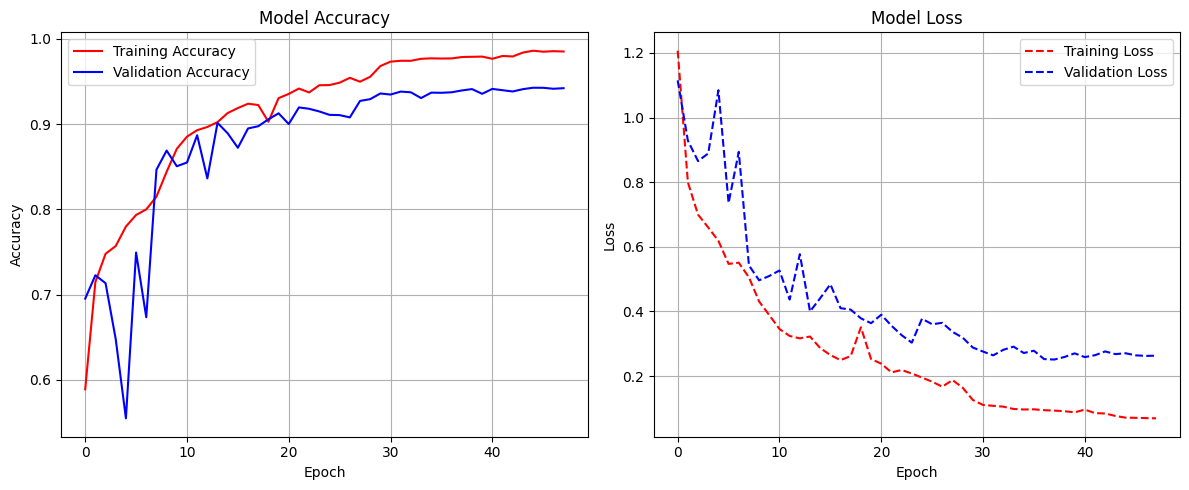

In [ ]:
plt.figure(figsize=(12, 5))

# 정확도
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'r-', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'b-', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 손실
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'r--', label='Training Loss')
plt.plot(history.history['val_loss'], 'b--', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 조정
plt.tight_layout()
plt.show()

In [ ]:

loss, accuracy = model.evaluate(x_test, y_test_hot, verbose=0)
print("="*40)
print(f"정확도 (Accuracy): {accuracy:.4f}")
print(f"손실 (Loss): {loss:.4f}")
print("="*40)

정확도 (Accuracy): 0.8540
손실 (Loss): 0.6509


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54876 (\N{HANGUL SYLLABLE HWAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

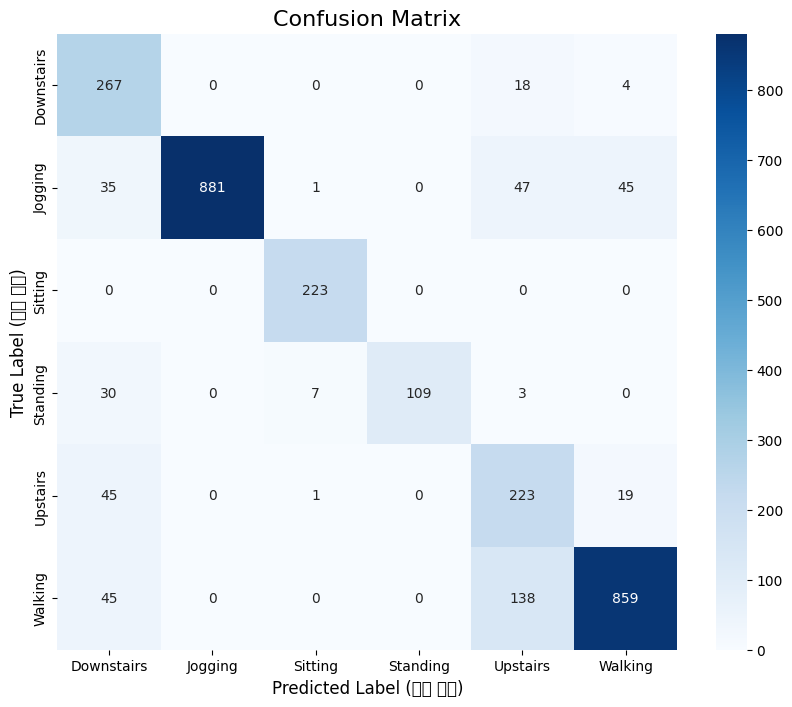

In [ ]:
# 1. 테스트 데이터에 대한 예측 수행
y_pred_probs = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# 2. Confusion Matrix 계산
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_classes)

# 3. Confusion Matrix 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label.classes_, yticklabels=label.classes_)
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label (실제 활동)', fontsize=12)
plt.xlabel('Predicted Label (예측 활동)', fontsize=12)
plt.show()

### LSTM + CNN

In [ ]:
%matplotlib inline

from tensorflow.keras.layers import MaxPool1D, LSTM, Dropout, Conv1D, GlobalAveragePooling1D, BatchNormalization, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2


model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(TIME_PERIOD, N_FEATURES), kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5)) #드롭아웃(0.4): 각 데이터마다 40%의 뉴런을 랜덤으로 비활성 시켜 과적합 방지

model.add(Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.5))


model.add(GlobalAveragePooling1D())
model.add(BatchNormalization())
model.add(Dense(6, activation='softmax'))

print(model.summary())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 80, 128)        │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 80, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 78, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 39, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 39, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,150 (461.52 KB)

 Trainable params: 117,894 (460.52 KB)

 Non-trainable params: 256 (1.00 KB)

None


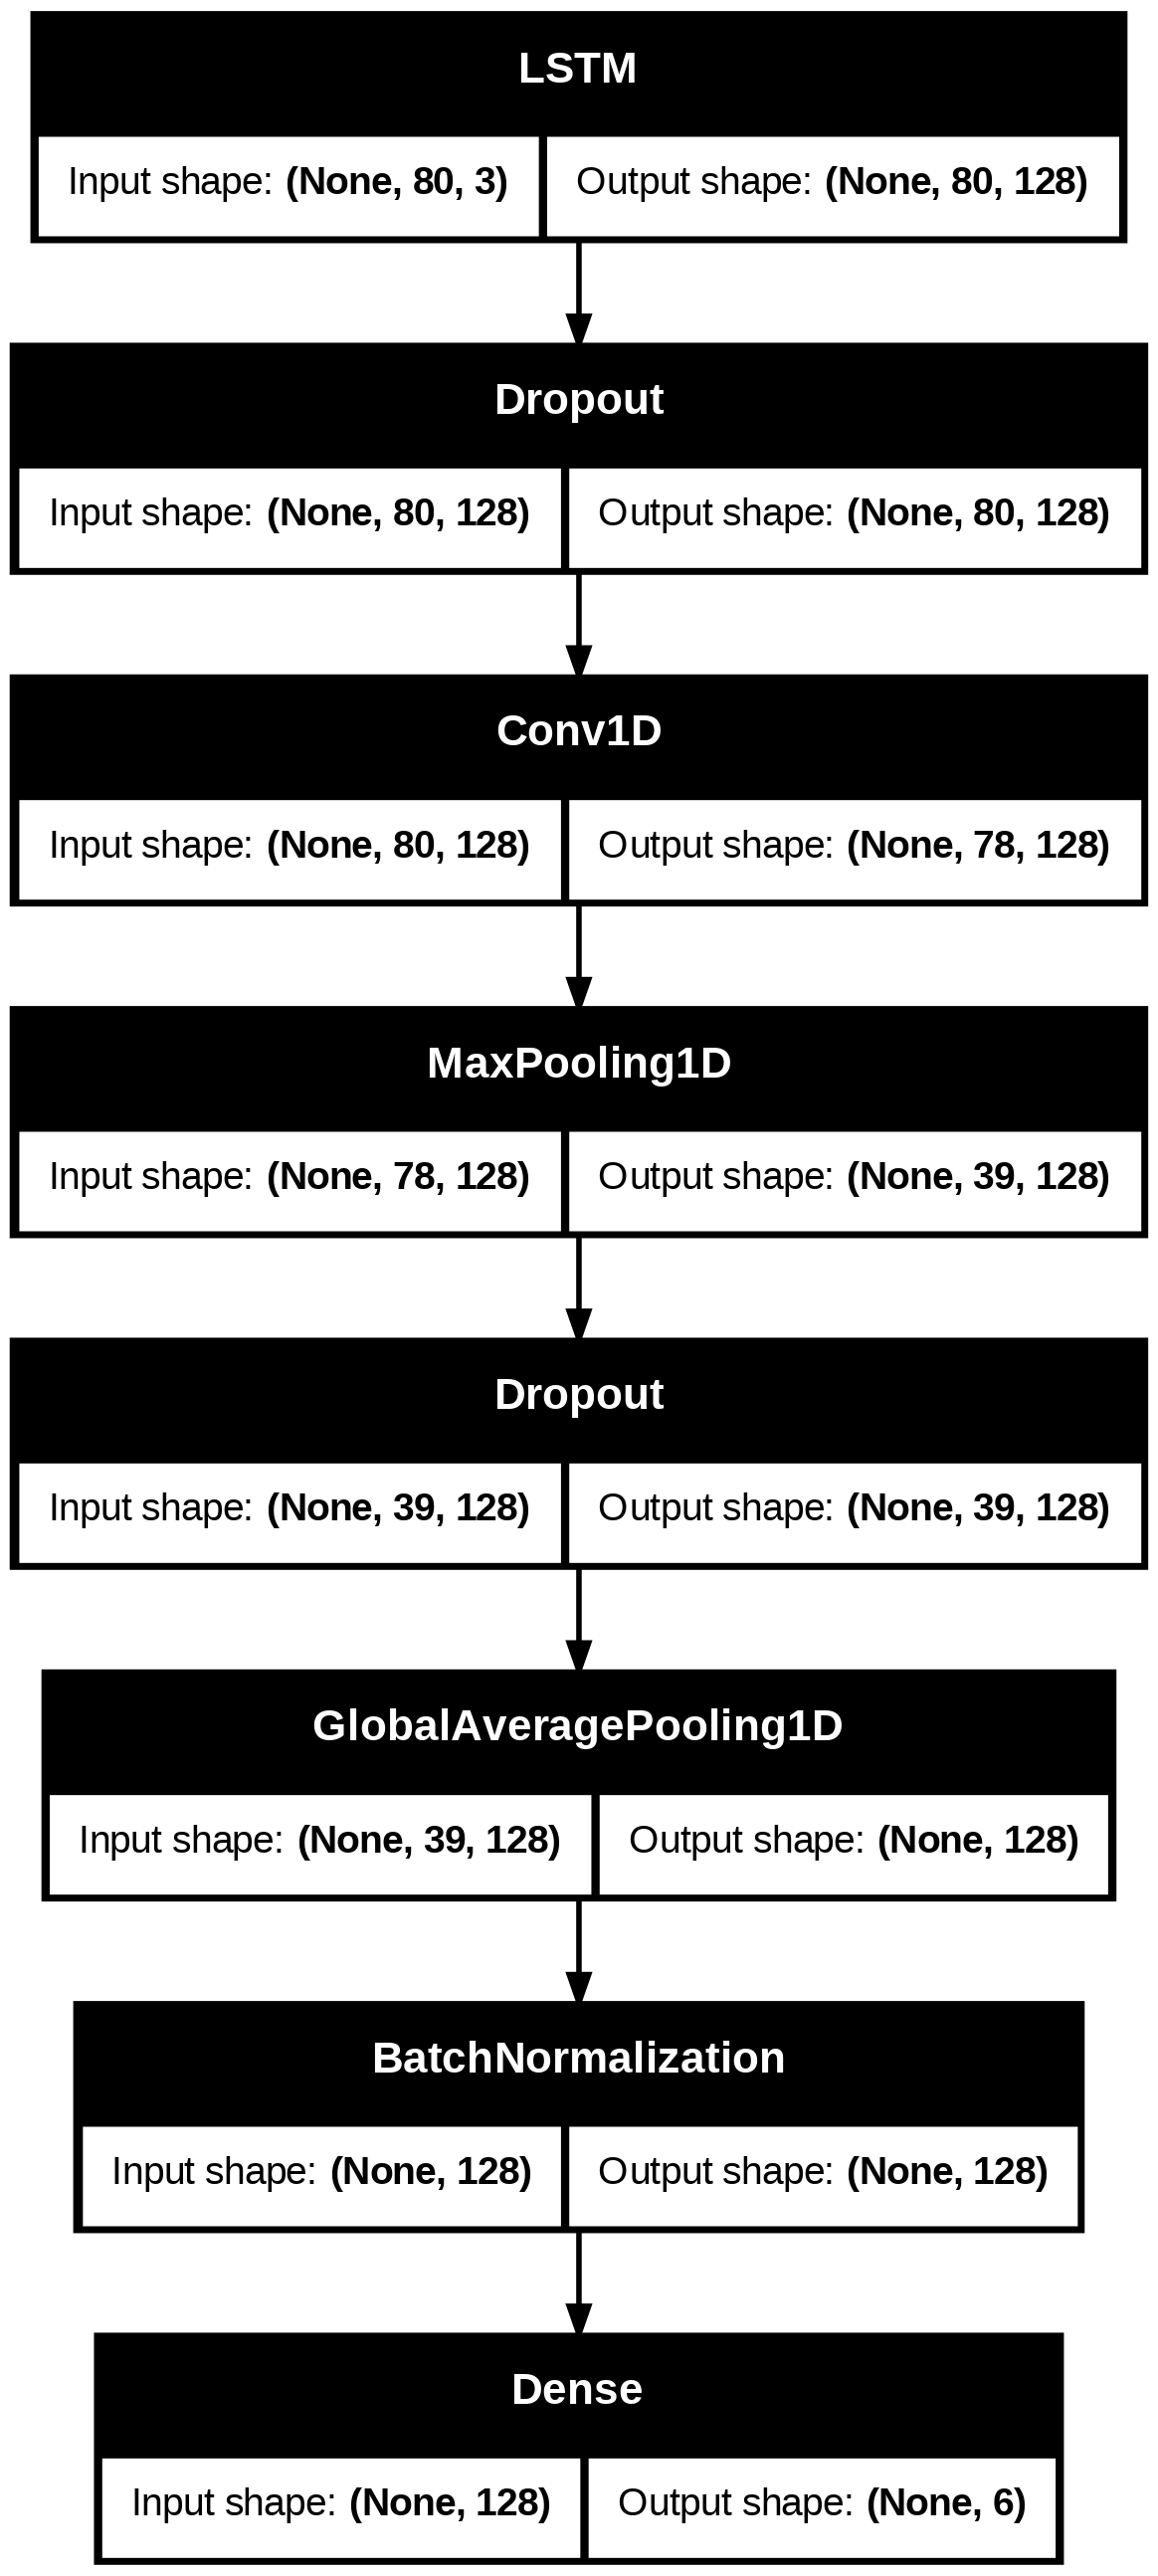

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

print("계산된 클래스 가중치:", class_weights_dict)

계산된 클래스 가중치: {0: np.float64(1.8377098963915683), 1: np.float64(0.5336393816785974), 2: np.float64(3.2721055979643765), 3: np.float64(4.111710631494804), 4: np.float64(1.4660823713837823), 5: np.float64(0.4253493756718763)}


In [ ]:
optimizer = Adam(learning_rate=0.0005)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
early_stop=EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=10,
    min_delta=0.0,
    restore_best_weights=True,
    verbose=1
)
history = model.fit(x_train,
                    y_train_hot,
                    batch_size= 192,
                    epochs=50,
                    callbacks=[early_stop],
                    validation_data=(x_val, y_val_hot),
                    class_weight=class_weights_dict,
                    verbose=1
                   )

Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.4424 - loss: 1.3517 - val_accuracy: 0.6240 - val_loss: 1.4915
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6657 - loss: 0.9257 - val_accuracy: 0.6754 - val_loss: 1.2941
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7074 - loss: 0.7744 - val_accuracy: 0.5373 - val_loss: 1.2589
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7329 - loss: 0.6885 - val_accuracy: 0.6450 - val_loss: 1.0318
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7611 - loss: 0.6406 - val_accuracy: 0.5976 - val_loss: 0.9971
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7791 - loss: 0.5938 - val_accuracy: 0.6876 - val_loss: 0.8437
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7968 - loss: 0.5548 - val_accuracy: 0.7671 - val_loss: 0.7594
Epoch 8/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8076 - loss: 0.5403 - val_accu

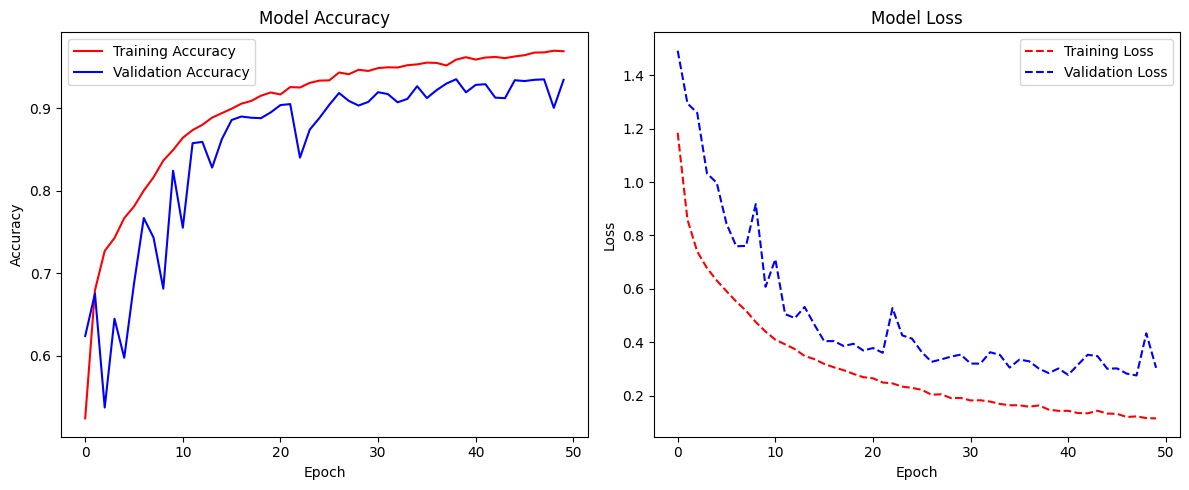

In [ ]:
plt.figure(figsize=(12, 5))

#정확도
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'r-', label='Training Accuracy') #훈련 정확도
plt.plot(history.history['val_accuracy'], 'b-', label='Validation Accuracy') #검증 정확도
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#손실
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'r--', label='Training Loss') #훈련 손실
plt.plot(history.history['val_loss'], 'b--', label='Validation Loss') #검증 손실
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout() # 그래프 간격 자동 조절
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


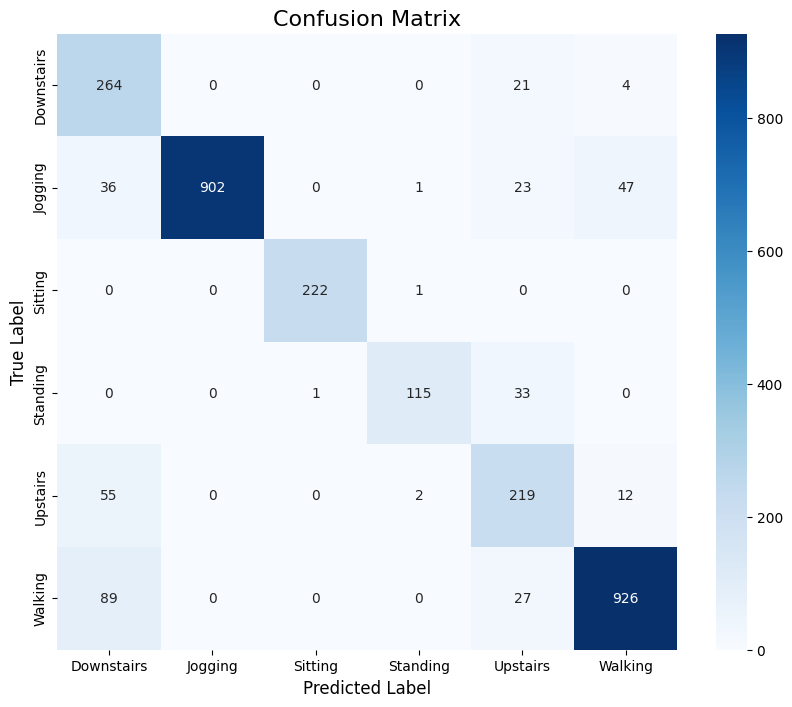

In [ ]:
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

#혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred)

#시각화
plt.figure(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label.classes_, yticklabels=label.classes_)

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

In [ ]:

loss, accuracy = model.evaluate(x_test, y_test_hot, verbose=0)
print("="*30)
print(f"테스트 데이터 정확도 (Accuracy): {accuracy:.4f}")
print(f"테스트 데이터 손실 (Loss): {loss:.4f}")
print("="*30)

테스트 데이터 정확도 (Accuracy): 0.8827
테스트 데이터 손실 (Loss): 0.5676
